In [29]:
# Run once only for flake8
%load_ext pycodestyle_magic
%pycodestyle_on or %flake8_on

3:21: E225 missing whitespace around operator
INFO:pycodestyle:3:21: E225 missing whitespace around operator
3:21: E225 missing whitespace around operator
INFO:pycodestyle:3:21: E225 missing whitespace around operator


The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [30]:
import os
import numpy as np
import torch
import pandas as pd
import pyro
import pyro.distributions as dist
import util_gmm as util_gmm

from collections import defaultdict
from matplotlib import pyplot
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, \
    config_enumerate, infer_discrete, EmpiricalMarginal
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc import NUTS
from pyro.infer import Predictive

%matplotlib inline
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('0.5.1')
pyro.enable_validation(True)
pyplot.style.use('ggplot')

## Gaussian Mixture Model for MovieLens dataset

#### Dataset:
* Main features are revenue, budget, popularity, vote_average, runtime, vote_count.
* Normalize features to avoid errors during numerical computation.

#### Priors:
* Choose 5-10 clusters based on the fact that there are:
* Several top movie genres: Comedy, Drama, Thriller, Action, Romance, Adventure. 
* Different release periods: 2010s, 2000s, 1990s, 1980s etc.

In [31]:
# Data processing
movies_metadata_dir = os.path.join("data", "movies_metadata_processed.csv")
movies_metadata = pd.read_csv(movies_metadata_dir)
data, data_new = util_gmm.get_train_test_split(movies_metadata)
movies_metadata[["revenue", "budget", "vote_count",
                 "vote_average", "popularity"]].head()

,revenue,budget,vote_count,vote_average,popularity
0,1.704938,-0.027262,3.741948,1.538049,0.880984
1,1.038238,0.844276,1.343043,0.675884,0.524078
2,-0.053369,-0.375877,-0.558021,-0.186280,-0.428077
3,0.584606,0.719771,0.921917,1.538049,0.589894
4,-0.156314,0.097244,-0.446146,-0.832904,-0.328774


### Experiment 1 (SVI and Normal Inverse-Gamma Prior):

### Model

Standard GMM model. Given $N$ data points, the likelihood is:
\begin{equation}
    p(x_n | \pi, \mu, \sigma^2) = \sum_{k=1}^{K} \pi_k N(x_n | \mu_k, \sigma_k^2)
\end{equation}

Define our priors $\pi \in [0,1]$ such that $\sum_{k=1}^{K} \pi_k = 1$
\begin{equation}
    \pi \sim Dir(\pi | \alpha \mathbb{1}_K)
\end{equation}

for fixed $\alpha = 1$, and for each $\mu_k \in \mathbb{R}^D$:
\begin{equation}
    \mu_k \sim Normal(\mu_k | 0, I)
\end{equation}

and for each component $\sigma_k^2 \in \mathbb{R}^D$:
\begin{equation}
    \sigma_k^2 \sim InvGamma(\sigma_k^2 | 1, 1)
\end{equation}

In [32]:
K = 8  # Clusters
d = len(data[0])  # Dimensions
N = len(data)  # Length of data

In [33]:
def model(data):
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(K)))
    with pyro.plate('component', K):
        locs = pyro.sample('locs', dist.MultivariateNormal(
            torch.zeros(d), torch.eye(d)))
        scale = pyro.sample('scale', dist.InverseGamma(1, 1))
    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        scale_ = scale[assignment].repeat(d, d, 1).transpose(2, 0)
        scale_ *= torch.eye(d).repeat(len(assignment), 1, 1)
        pyro.sample('obs', dist.MultivariateNormal(
            locs[assignment], scale_), obs=data)


global_guide = AutoDelta(
    poutine.block(model, expose=['weights', 'locs', 'scale']))

### Inference

Here, we run SVI and get the MAP estimates of the posterior for $\pi, \mu, \sigma^2$.

In [34]:
optim = pyro.optim.Adam({'lr': 0.1})
elbo = TraceEnum_ELBO()
svi = SVI(model, global_guide, optim, loss=elbo)

In [35]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    loss = svi.loss(model, global_guide, data)
    return loss


loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, init loss = {}'.format(seed, loss))

seed = 87, init loss = 4406.3232421875


In [36]:
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(
        lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(500):
    loss = svi.step(data)
    losses.append(loss)

In [37]:
# Get MAP Estimates
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']

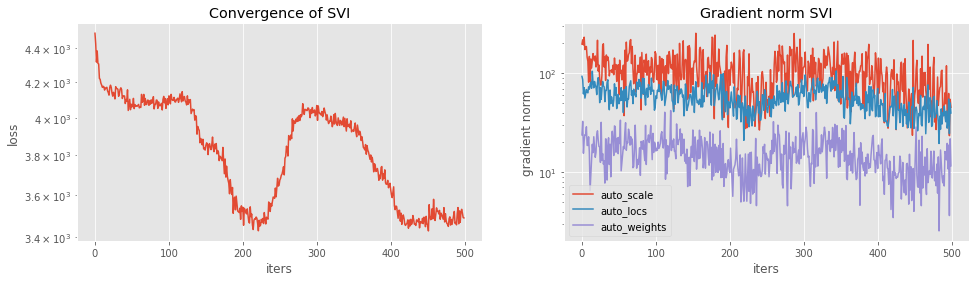

In [38]:
util_gmm.plot_svi_convergence(losses, gradient_norms)

#### Issues:
* The ELBO seems to decrease in general but increases midway. Gradients of scale, locs and weights are noisy.
* Prior collapses to the same point during SVI, i.e. clusters tend to converge together.
* Not fully probabilistic - Inverse Gamma prior for variance does not capture cross-covariances!

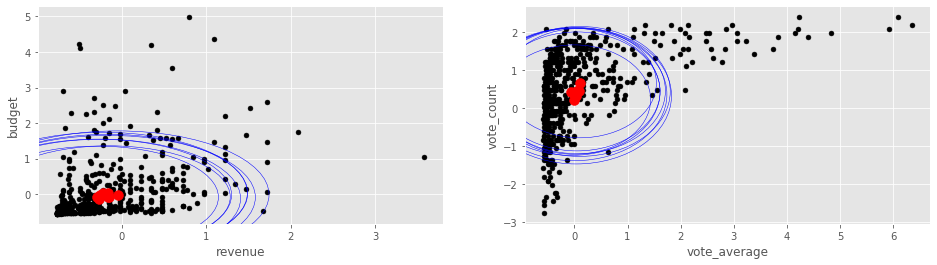

In [39]:
fig = pyplot.figure(figsize=(16, 4))
ax = fig.add_subplot(121, xlabel="revenue", ylabel="budget")
util_gmm.plot(data[:, 0:2], locs[:, 0:2], scale, K=K, d=d, ax=ax)
ax = fig.add_subplot(122, xlabel="vote_average", ylabel="vote_count")
util_gmm.plot(data[:, 2:4], locs[:, 2:4], scale, K=K, d=d, ax=ax)

#### Alternative:
* Consider MCMC for full posterior over components.
* For multivariate covariance matrix, a conjugate prior is the Inverse-Wishart distribution [Gelmen et al., 2003].
* However, the Inverse Wishart is not a suitable prior. 
* **Why?** First, positive-definite and symmetric constraints of the probability of generating valid samples is low. Second, the Wishart distribution is heavy-tailed; which are obstructions to ergodicity which is requirement for MCMC. Further, when tails are heavy, samplers may drift around which can be difficult to return back to heavy mass (high computational costs).

#### Solution:
* Use LKJCorr Prior for full probabilistic covariance [Barnard, McCulloch & Meng, 2000]
* LKFCorr distribution has lighter tails which pairs better with MCMC.
* Cholesky factorization for faster computation, $\Sigma= L L^T$


### Experiment 2 (NUTS and Normal LKJ Correlation Cholesky Prior):

### Model
Given the same setup as before:
\begin{align}
    \pi &\sim Dir(\pi | \alpha \mathbb{1}_K) \\
    \mu_k &\sim Normal(\mu_k | 0, I)
\end{align}

Define the covariance matrix as:
\begin{equation}
    \Sigma = diag(\theta) \Omega diag(\theta) \iff \Omega_{i,j} = \Sigma_{i,j} (\theta_i \theta_j)^{-1}
\end{equation}

Set priors where $\theta_k$ is the scale vector and $\Omega$ is the correlation matrix defined by
\begin{align}
    \theta_k &\sim HalfCauchy(1) \\
    \Omega_k &\sim LKJCorr(\eta) \\
\end{align}

The LKJ correlation distribution is defined by
\begin{equation}
    LKJCorr(\Sigma | \eta) \propto det(\Sigma)^{\eta -1}
\end{equation}

In [40]:
def model(data):
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(K)))
    theta = pyro.sample("theta", dist.HalfCauchy(1*torch.ones(d)).to_event(1))
    eta = torch.ones(1)
    L_omega = pyro.sample("L_omega", dist.LKJCorrCholesky(d, eta))
    L_Omega = torch.mm(torch.diag(theta.sqrt()), L_omega)
    with pyro.plate('components', K):
        mu = pyro.sample('locs', dist.MultivariateNormal(
            torch.zeros(d), 1*torch.eye(d)))
    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample("obs", dist.MultivariateNormal(
            mu[assignment], scale_tril=L_Omega), obs=data)


global_guide = AutoDelta(
    poutine.block(model, expose=['weights', 'locs', 'L_omega']))

### Inference

Perform the following steps:
* Run NUTS MCMC over 250 samples.
* Draw the trace plots of the posterior samples.
* Compute the Bayes estimate of $\pi, \mu, \Sigma$. 
* Note: Set step size to 1e-4 or lower to avoid LAPACK errors for LKJCorr prior.

In [41]:
pyro.set_rng_seed(2)
kernel = NUTS(model, step_size=1e-4)
mcmc = MCMC(kernel, num_samples=250, warmup_steps=50)
mcmc.run(data)
posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 300/300 [04:25,  1.13it/s, step size=3.88e-02, acc. prob=0.854]


In [42]:
Sigma_samples = util_gmm.get_Sigma_samples(posterior_samples)
cov = util_gmm.get_bayes_estimate_cov(Sigma_samples, K)
mu = util_gmm.get_bayes_estimate_mu(posterior_samples)
pi = util_gmm.get_bayes_estimate_pi(posterior_samples)

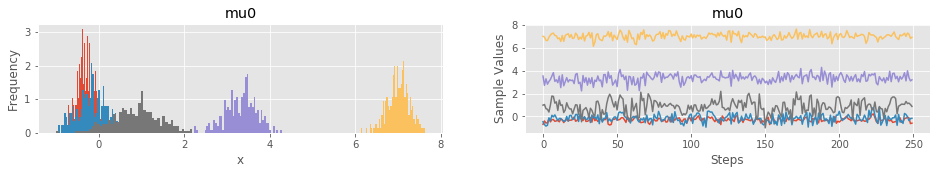

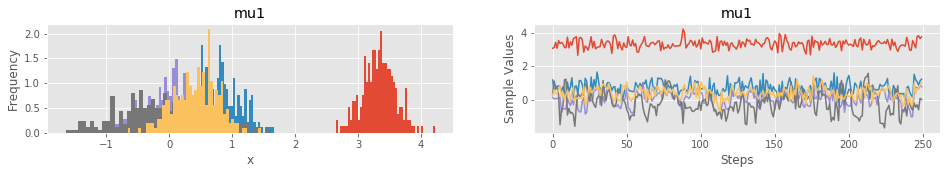

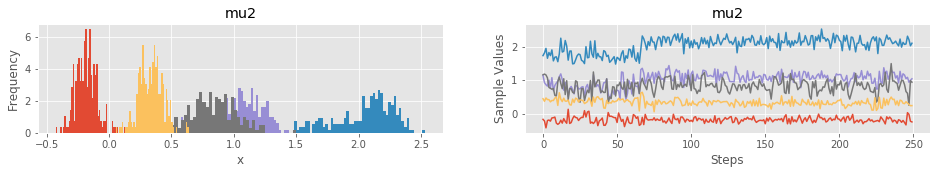

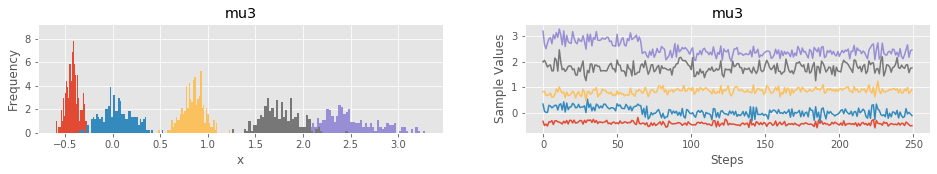

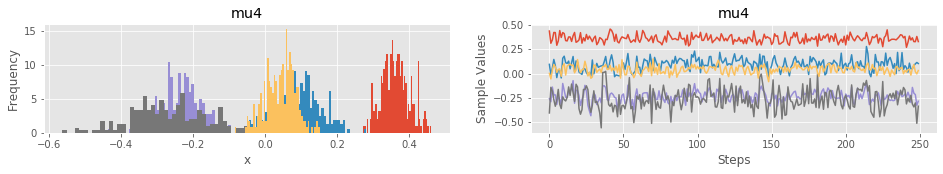

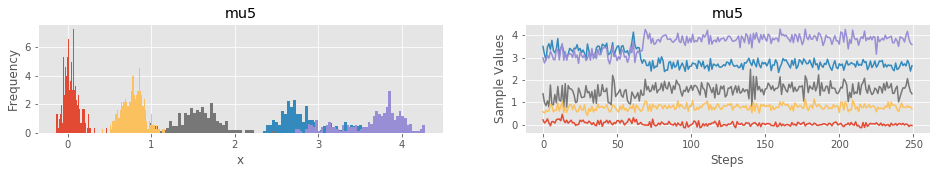

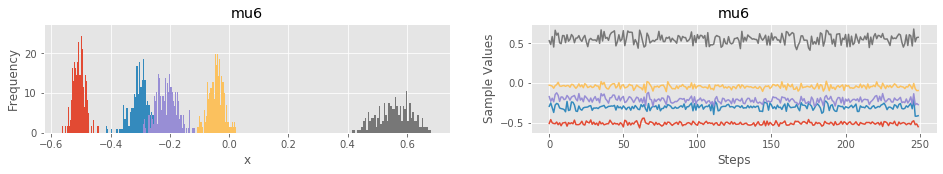

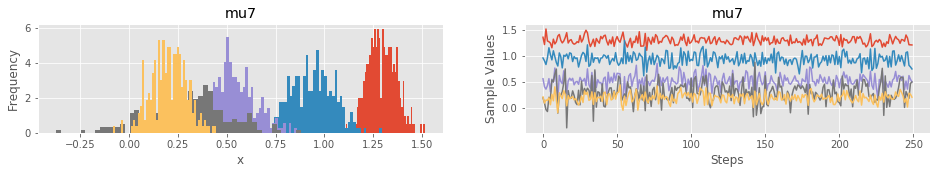

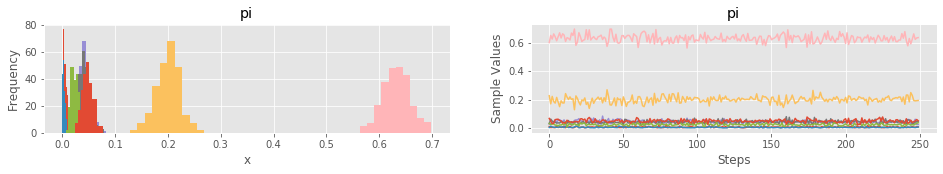

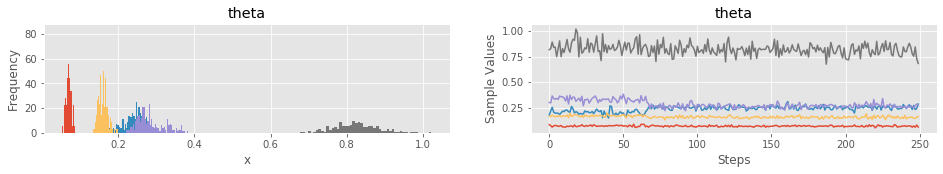

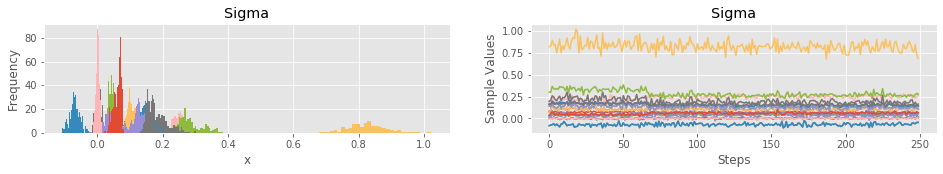

In [43]:
util_gmm.plot_mcmc_mu(posterior_samples, K, d)
util_gmm.plot_mcmc_pi(posterior_samples, K, d)
util_gmm.plot_mcmc_theta(posterior_samples, K, d)
util_gmm.plot_mcmc_Sigma(Sigma_samples, K, d)

#### Issues
* Components $\mu, \Sigma$ seem to capture the general distribution of the data well.
* But most of the density within the Mixture Model is clustered within a single component.

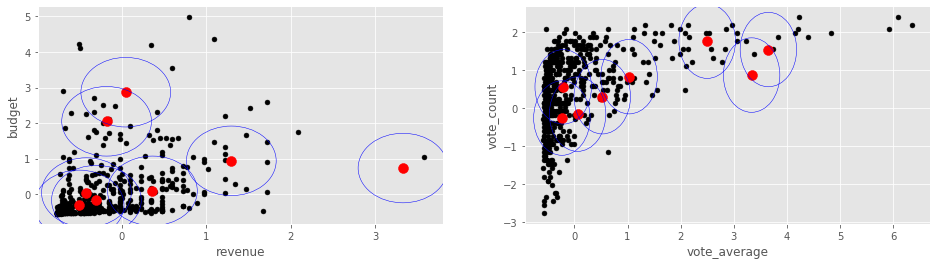

In [44]:
fig = pyplot.figure(figsize=(16, 4))
ax = fig.add_subplot(121, xlabel="revenue", ylabel="budget")
util_gmm.plot(data[:, 0:2], mu[:, 0:2], cov, K=K, d=d, ax=ax)
ax = fig.add_subplot(122, xlabel="vote_average", ylabel="vote_count")
util_gmm.plot(data[:, 2:4], mu[:, 2:4], cov, K=K, d=d, ax=ax)

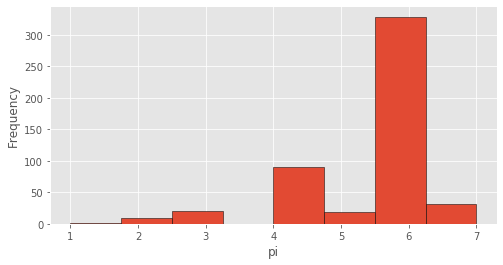

In [45]:
predictive = Predictive(model, posterior_samples)
assignment = predictive.get_samples(data)["assignment"][-1, :]
pyplot.figure(figsize=(8, 4))
pyplot.hist(assignment, bins=K, ec="k")
pyplot.xlabel("pi")
pyplot.ylabel("Frequency")
pyplot.show()

## Criticism

### Posterior Predictive Checks

A powerful model-checking procedure that performs the following:
* Simulate replicated data from the posterior predictive distribution.
* Compute a discrepancy that measures "relevance".
* Compare distance between discrepancy of observed data to replicated data.

More formally, A PPC is defined by:
\begin{equation}
    PPC(x^{obs}; g, d) = E[g(d(x^{rep}, \theta), d(x^{obs}, \theta)) | x^{obs}]
\end{equation}
Where the realized discrepancy $d(y, \theta)$ is a function of both data and hidden variables [Ranganath & Blei, 2019] and $g(\cdot, \cdot)$ is a distance function.

One realized discrepancy is the log-likelihood:
\begin{align}
    d(x, \theta) 
    &= \sum_{i=1}^{n} \log p(x_i | \theta) \\
    &= \sum_{i=i}^{n} \log \Big[ \sum_{k=1}^{K} \pi_k N(x_i; \mu_k, \Sigma_k) \Big]
\end{align}

In [51]:
data_rep = []
for i in range(N):
    cluster = pyro.sample('category', dist.Categorical(torch.tensor(pi)))
    idx = cluster.item()
    sample = pyro.sample("obs", dist.MultivariateNormal(mu[idx], cov[idx]))
    while sample[0] < min(data[:, 0]) or sample[1] < min(data[:, 1]):
        # Only sample valid points
        sample = pyro.sample("obs", dist.MultivariateNormal(mu[idx], cov[idx]))
    data_rep.append(sample.tolist())
data_rep = torch.tensor(data_rep)

In [54]:
d_obs = util_gmm.compute_log_likelihood(data, mu, cov, pi)
d_rep = util_gmm.compute_log_likelihood(data_rep, mu, cov, pi)

ppc = np.sqrt((d_obs - d_rep)**2)
print('Discrepancy of observed data: {}'.format(d_obs))
print('Discrepancy of replicated data: {}'.format(d_rep))
print('Posterior Predictive Check: {}'.format(ppc))

Discrepancy of observed data: -193525.6875
Discrepancy of replicated data: -190805.0625
Posterior Predictive Check: 2720.625


### Population Predictive Checks

__Issue__: PPCs tend to overfit due to "double dipping" the data, i.e. we compute the discrepancy of replicated data based on latent variables we obtained from the observed data.

__Solution__: Population Predictive Checks [Ranganath & Blei, 2019]. Use Bootstrap or Cross-validation to obtain $x^{new}$ to model the true distribution F. This follows the intuition: “If my model is good (in a relevant way) then data drawn from the posterior predictive distribution of a group will look like data from the true population of that group.”

A POP-PC is defined by
\begin{equation}
    POP-PC(x^{obs}, F; g, d) = E[g(d(x^{rep}, \theta), d(x^{new}, \theta)) | x^{obs}, F]
\end{equation}

In [55]:
d_new = util_gmm.compute_log_likelihood(data_new, mu, cov, pi)
d_rep = util_gmm.compute_log_likelihood(data_rep, mu, cov, pi)

pop_pc = np.sqrt((d_new - d_rep)**2)
print('Discrepancy of new data: {}'.format(d_new))
print('Discrepancy of replicated data: {}'.format(d_rep))
print('Population Predictive Check: {}'.format(pop_pc))

Discrepancy of new data: -192572.578125
Discrepancy of replicated data: -190805.0625
Population Predictive Check: 1767.515625


### Hallucinated Data Simulation.

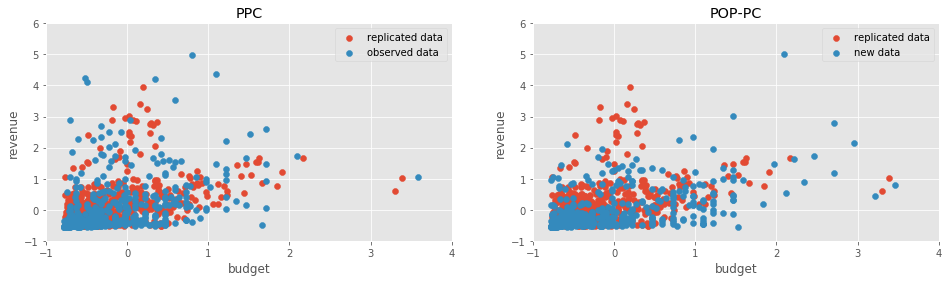

In [56]:
fig = pyplot.figure(figsize=(16, 4))
ax1 = fig.add_subplot(
    121, xlabel="budget", ylabel="revenue",
    title="PPC", ylim=(-1, 6), xlim=(-1, 4))
ax1.scatter(data_rep[:, 0], data_rep[:, 1], label="replicated data")
ax1.scatter(data[:, 0], data[:, 1], label="observed data")
ax1.legend()
ax2 = fig.add_subplot(
    122, xlabel="budget", ylabel="revenue",
    title="POP-PC", ylim=(-1, 6), xlim=(-1, 4))
ax2.scatter(data_rep[:, 0], data_rep[:, 1], label="replicated data")
ax2.scatter(data_new[:, 0], data_new[:, 1], label="new data")
ax2.legend()

### Choosing number of cluster based on PPC and POP-PC 
* Data is collected by repeating the experiements above and changing the value of K to observe how PPCs/POP-PCs respond.
* In general, POP-PCs are higher than PPCs which is an expected result since we are evaluating the replicated data against new data.
* As $K$ increases from 10 onwards, the discrepancy of POP-PCs increases while PPCs do not increase as much.
* Zig-zag values possibly due to nature of dataset; where there may be an __even__ number of clusters.
* Suggests that around 6, 8 or 10 clusters is an optimal value.

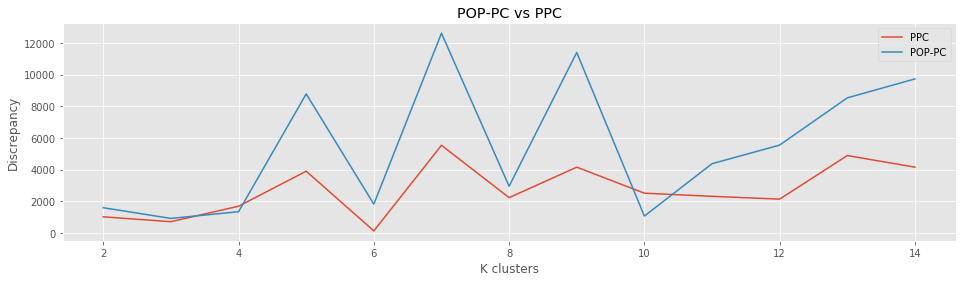

In [50]:
K_variable = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
ppc_response = [1028425, 499302, 2828440, 15175103, 15331, 30597838,
                4952241, 17231320, 6284324, 5327910, 4547856, 23852158,
                17231514]

pop_pc_response = [2522314, 833008, 1790494, 77044920, 3299700,
                   158990000, 8688746, 129820000, 1125285, 19079732,
                   30745118, 72734376, 94568328]

fig = pyplot.figure(figsize=(16, 4))
ax = fig.add_subplot(
    111, xlabel="K clusters", ylabel="Discrepancy", title="POP-PC vs PPC")
ax.plot(K_variable, np.sqrt(ppc_response), label="PPC")
ax.plot(K_variable, np.sqrt(pop_pc_response), label="POP-PC")
ax.legend()

### Conclusion
* Non-identifiability of clusters is a challenge in this dataset.
* NUTS MCMC performs better than SVI.
* LKJCorr prior captures full probabilistic covariance.
* Combining POP-PCs and PPCs to choose number of clusters.